<a href="https://colab.research.google.com/github/Hase-U/learn_pytorch_advanced/blob/master/mycode/2_objectdetection/SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 物体検出
commit用

```mycode/2_objectdetection/```



In [0]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import time
from google.colab import files
import xml.etree.ElementTree as ET 
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## 2-1物体検出とは
**バウンディングボックス(bounding box)：**物体の位置を表す枠

インプット：画像

アウトプット：
- 画像のどこに物体が存在するかを示すバウンディングボックスの位置と大きさ情報
- 各バウンディングボックスに何が写っているか
- その検出に対する確信度

### SSDの流れ
デフォルトボックスの数がN, クラスが背景を入れてO+1の場合
1. 画像のリサイズ
2. デフォルトボックスを準備(N個)
3. 画像をSSDネットワークに入力(出力 N$\times$(O+1+4(オフセット)))
4. 信頼度上位のデフォルトボックスを抽出
5. オフセット情報による修正と被りの除去
6. 閾値を超える信頼度のもののみを最終出力にする

## 2-2 Datasetの実装
データセットがめちゃ大きくてダウンロードに15分毎回かかるから他にいい方法がないか以下を試した
- ```!wget```して解凍
- ファイルをアップロード
- Google drive でマウント

多分```!wget```を毎回するのが一番早いと思われ

In [2]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar xf VOCtrainval_11-May-2012.tar

--2020-04-03 11:20:33--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  77.7MB/s    in 25s     

2020-04-03 11:25:19 (76.3 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [0]:
!ls

In [0]:
from google.colab import drive
drive.mount('/content/drive')

### 画像データ、アノテーションデータへのファイルパスリストを作成
**アノテーション**：正解データ。今回で言えば画像のどこに何があるかというバウンディングボックスの情報を指す

In [0]:
# 画像データとアノテーションデータへのファイルパスリストを作成する

def make_datapath_list(rootpath):

  # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
  imgpath_template = osp.join(rootpath, "JPEGImages", "%s.jpg")
  annopath_template = osp.join(rootpath, "Annotations", "%s.xml")

  #訓練と検証、それぞれのファイルのIDを取得する
  train_id_names = osp.join(rootpath+"ImageSets/Main/train.txt")
  val_id_names = osp.join(rootpath+"ImageSets/Main/val.txt")

  # 訓練データの画像ファイルとアノテーションファイルへのパスリストを作成
  train_img_list = list()
  train_anno_list = list()

  for line in open(train_id_names):
    file_id = line.strip()
    img_path = (imgpath_template % file_id) #画像パス
    anno_path = (annopath_template % file_id) #アノテーションのパス
    train_img_list.append(img_path)
    train_anno_list.append(anno_path)

    #検証データの画像ファイルとアノテーションファイルへのパスリストの作成
    val_img_list = list()
    val_anno_list = list()

  for line in open(val_id_names):
    # print(file_id)
    file_id = line.strip()
    img_path = (imgpath_template % file_id) #画像パス
    anno_path = (annopath_template % file_id) #アノテーションのパス
    val_img_list.append(img_path)
    val_anno_list.append(anno_path)   
  
  """
  それぞれで何が起きてるか確認用
  """
  # print("line : ", line)
  # print("file_id : ",file_id)
  # print("annopath_template : ",annopath_template)
  # print("anno_path : ",anno_path)

  return train_img_list, train_anno_list, val_img_list, val_anno_list

In [6]:
# 動作確認
rootpath = "./VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

print("----------------------------")

print(train_img_list[0])

line :  2011_003275

file_id :  2011_003275
annopath_template :  ./VOCdevkit/VOC2012/Annotations/%s.xml
anno_path :  ./VOCdevkit/VOC2012/Annotations/2011_003275.xml
----------------------------
./VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg


In [0]:
!ls

### xml形式のアノテーションデータをリストに変換

In [0]:
# XML形式をリスト形式に変換する

class Anno_xml2list(object):
  #objectは今から入力する画像の中に存在し得る物体のリスト


  def __init__(self, classes):
    self.classes = classes

  def __call__(self, xml_path, width, height):

    # 画像内の全ての物体のアノテーションをこのリストに格納する
    res = []

    # xmlファイルを読み込む
    xml = ET.parse(xml_path).getroot()

    # 画像内にある物体(object)の数だけループする
    for obj in xml.iter("object"):
      
      #アノテーションで検知がdifficultに設定されているものは除外
      difficult = int(obj.find("difficult").text)
      if difficult == 1:
        continue
      
      #１つの物体に対するアノテーションを格納するリスト
      bndbox = []

      name = obj.find("name").text.lower().strip() #小文字揃えにして改行、空白をのぞいてる
      bbox = obj.find("bndbox") #バウンディボックスの情報

      # アノテーションのxmin, ymin, xmax, ymaxを取得して、[0,1]で正規化
      pts = ["xmin", "ymin", "xmax", "ymax"]

      for pt in pts:
        #VOCは原点が(1,1)なので(0,0)に
        cur_pixel = int(bbox.find(pt).text) - 1

        # 幅、高さで正規化
        if pt =="xmin" or pt == "xmax": 
          cur_pixel /= width   
        else:
          cur_pixel /= height

        bndbox.append(cur_pixel)
      
      # アノテーションのクラス名のindexを取得して追加
      label_idx = self.classes.index(name)
      bndbox.append(label_idx)

      #　resに["xmin", "ymin", "xmax", "ymax", "label_idx"]を加える
      res += [bndbox]

    return np.array(res)


In [52]:
#動作確認
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

#画像の読み込み
ind = 1
image_file_path = val_img_list[1]
img = cv2.imread(image_file_path)
height , width, channlels = img.shape

transform_anno(val_anno_list[ind], width, height)

array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

### 画像とアノテーションの前処理を行うクラスDataTransformを作成
データオーギュメンテーションは著者にしたがって参考文献に紹介されているものを転用する。よってデータの読み込むにはPILではなくOpenCV(cv2)を利用する。

注意点としてはOpenCVはデータが **[高さ], [幅], [色BGR]** の順になっている点である。特に色はRGBではなくBGRになっているので注意が必要である。

In [0]:
# データオーギュメンテーションに必要なものはimportする
from data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords,\
PhotometricDistort,Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans

class DataTransform():


  def __init__(self, input_size, color_mean):
    self.data_transform = {
        "train":Compose([
                         ConvertFromInts(), # intをfloat32
                         ToAbsoluteCoords(), # アノテーションデータの規格化を戻す
                         PhotometricDistort(), # 画像の色調などをランダムに変更
                         Expand(color_mean), # 画像のキャンバスを広げる
                         RandomSampleCrop(), # 画像内の部分をランダムに抜き出す
                         RandomMirror(), #　画像を反転させる
                         ToPercentCoords(), # アノテーションデータを[0,1]に規格化
                         Resize(input_size), 
                         SubtractMeans(color_mean)
        ]),
      "val":Compose([
                     ConvertFromInts(), 
                     Resize(input_size),
                     SubtractMeans(color_mean)
      ])
    }
  
  def __call__ (self, img, phase, boxes, labels):

    return self.data_transform[phase](img, boxes, labels)

original


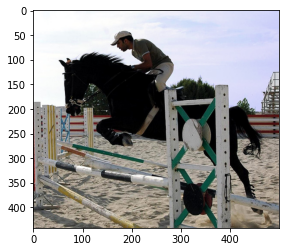

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train


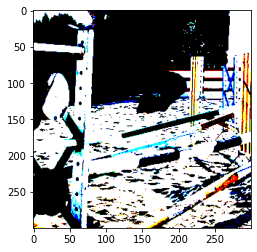

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


val


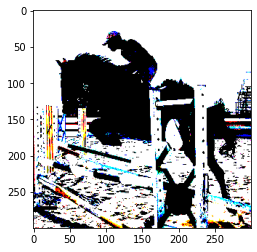

[12. 14.]


In [80]:
# 動作確認
id = 0

# 画像の読み込み
image_file_path = train_img_list[id]
img = cv2.imread(image_file_path)
height, width, channels = img.shape

# アノテーションをリストに
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[id], width, height)

# 元画像の表示
print("original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 前処理クラスの作成
color_mean = (104, 117, 123)
input_size = 300
transform = DataTransform(input_size, color_mean)

# train画像の表示
print("train")
phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4]) #anno_list[:, :4]:位置情報 ,anno_list[:, 4]:ラベル
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

# val画像の表示
print("val")
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

print(labels) 

```labels```が[12,14]なのでidが12と14のものが写っていることが分かる

In [86]:
for id in labels:
  print(voc_classes[int(id)])

horse
person


### Datasetの作成


In [0]:
class VOCDataset(data.Dataset):

  def __init__(self, img_list, anno_list, phase, transform, transform_anno):
    self.img_list = img_list
    self.anno_list = anno_list
    self.phase = phase
    self.transform = transform # 画像の変形
    self.transform_anno = transform_anno #xml2lim



  def __len__(self):
    #画像の枚数を返す
    return len(self.img_list)

  def __getitem__(self, index):
    # 前処理した画像のテンソル形式のデータとアノテーションを取得

    im, gt, h, w = self.pull_item(index)
    return im, get_ipython

  def pull_item(self, index):
    # 前処理した画像のテンソル形式のデータ、アノテーション、画像の高さ、幅を取得する

    #画像の読み込み
    image_file_path = self.img_list[index]
    img = cv2.imread(image_file_path)
    height, width, channels = img.shape

    # xml形式のアノテーション情報をリストに
    anno_file_path = self.anno_list[index]
    anno_list = self.transform_anno(anno_file_path, width, height)

    # 前処理を実施
    img, boxes, labels = self.transform(
        img, self.phase, anno_list[:,:4], anno_list[:,4])
    #色チャネルをBGRからRGBに変換
    img = torch.from_numpy(img[:,:,(2,1,0)]).permute(2,0,1)

    #BBoxとラベルをセットしたnp.array
    gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

    return img, gt, height, width

In [100]:
#動作確認
color_mean = (104, 117, 123)
input_size = 300

train_dataset = VOCDataset(train_img_list, train_anno_list, phase = "train",
                           transform=DataTransform(input_size, color_mean),
                           transform_anno = Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase = "val",
                           transform=DataTransform(input_size, color_mean),
                           transform_anno = Anno_xml2list(voc_classes))

val_dataset.__getitem__(1)

(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9082,  -13.2200,
             -9.4034],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9501,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2816,  -20.1750,   -5.5633,  ..., -104.9934, -111.8350,
           -119.0000],
          [ -20.4766,  -21.0000,  -12.6334,  ..., -107.1685, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0766,  -14.7250,
            -11.8534],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5016,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9501,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2